In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `~/Study/ML-Playbook`


In [2]:
using Flux, CUDA, Statistics, ProgressMeter

In [6]:
noisy = rand(Float32, 2, 1000);                                   
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)];

In [7]:
noisy

2×1000 Matrix{Float32}:
 0.934829   0.799397  0.0717252  0.223358  …  0.417526  0.0939855  0.376074
 0.0178976  0.619698  0.147657   0.405913     0.483335  0.447924   0.0318747

In [8]:
truth

1000-element Vector{Bool}:
 1
 0
 0
 0
 0
 0
 1
 0
 1
 0
 ⋮
 1
 0
 1
 1
 0
 1
 0
 0
 0

In [10]:
model = Chain(
    Dense(2 => 3, tanh),   # A dense layer with 2 inputs and 3 outputs, using the tanh activation function
    BatchNorm(3),          # Batch normalization applied to the 3-dimensional output from the previous layer
    Dense(3 => 2)          # A dense layer with 3 inputs and 2 outputs
) |> cpu                  # Move the model to the CPU

Chain(
  Dense(2 => 3, tanh),                  # 9 parameters
  BatchNorm(3),                         # 6 parameters, plus 6
  Dense(3 => 2),                        # 8 parameters
)         # Total: 6 trainable arrays, 23 parameters,
          # plus 2 non-trainable, 6 parameters, summarysize 604 bytes.

In [17]:
# Example of a forward pass
out1 = model(noisy) |> cpu
probs1 = softmax(out1)

2×1000 Matrix{Float32}:
 0.521627  0.57828  0.518021  0.549438  …  0.561994  0.549275  0.515709
 0.478373  0.42172  0.481979  0.450562     0.438006  0.450725  0.484291

In [18]:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target) |> cpu, batchsize=64, shuffle=true);

In [19]:
optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

# Training loop, using the whole data set 1000 times:
losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.logitcrossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


In [20]:
optim

(layers = ((weight = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.00499094 0.00124339; -0.119892 -0.0567024; -0.0151309 -0.0209075], Float32[0.017602 0.0125414; 0.365942 0.035195; 0.00811614 0.0169], (6.0f-45, 1.11549f-7))), bias = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.00302284, 0.0725614, -0.0220172], Float32[0.0573742, 0.145511, 0.0229471], (6.0f-45, 1.11549f-7))), σ = ()), (λ = (), β = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0443743, -0.0535652, -0.039532], Float32[0.0405557, 0.0615612, 0.0333449], (6.0f-45, 1.11549f-7))), γ = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0386793, -0.0201344, -0.0230864], Float32[0.0194123, 0.0155521, 0.0118138], (6.0f-45, 1.11549f-7))), μ = (), σ² = (), ϵ = (), momentum = (), affine = (), track_stats = (), active = (), chs = ()), (weight = Leaf(Adam(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0327355 0.0135515 0.0153266; -0.0327355 -0.0135515 -0.0153267], Float32[0.0130057 0.00849117 0.0064689; 0.0130057 0.00849116 0.00

In [21]:
out2 = model(noisy)  # first row is prob. of true, second row p(false)
probs2 = softmax(out2)      # normalise to get probabilities
mean((probs2[1,:] .> 0.5) .== truth)

0.959

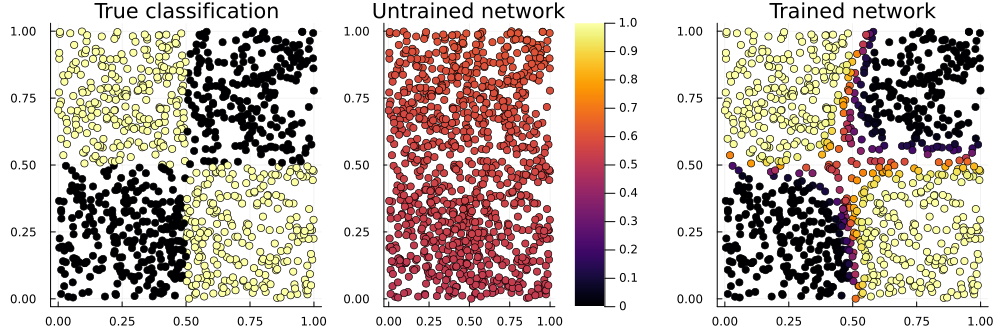

In [24]:
using Plots  # to draw the above figure

p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false)
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=probs1[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=probs2[1,:], title="Trained network", legend=false)

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,330))

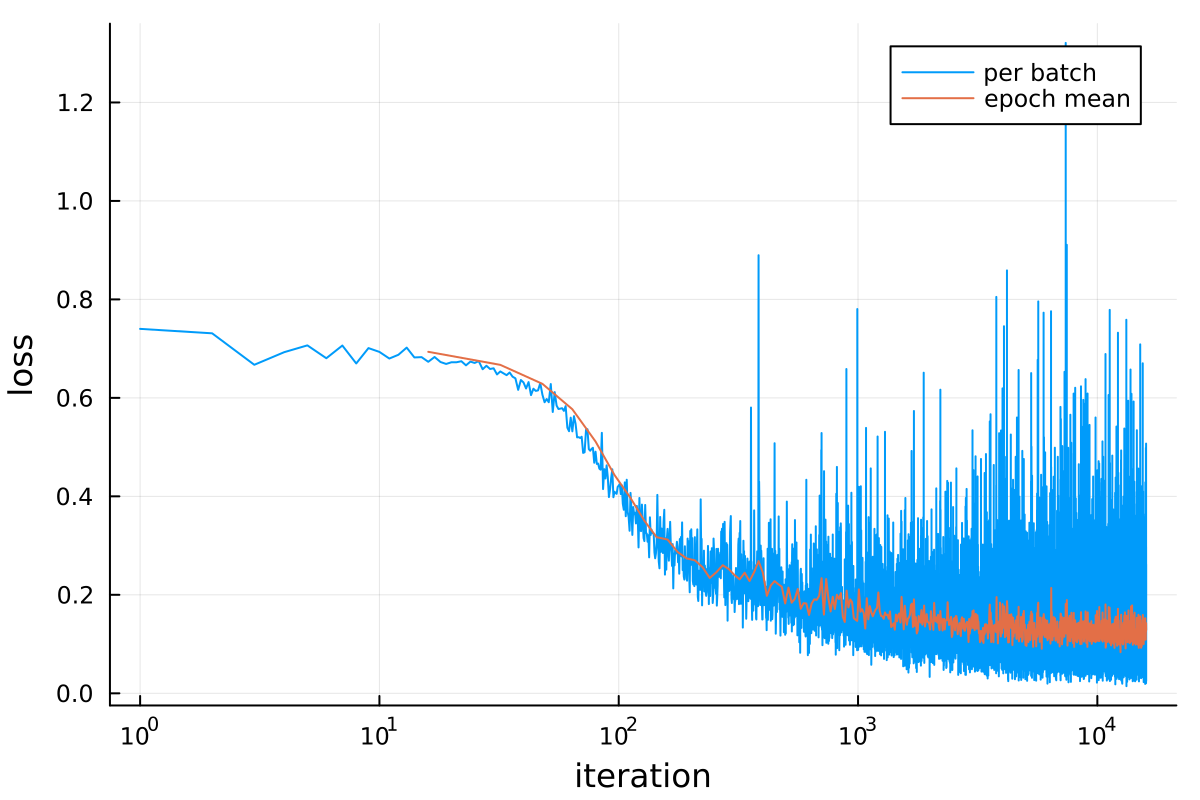

In [25]:
plot(losses; xaxis=(:log10, "iteration"),
    yaxis="loss", label="per batch")
n = length(loader)
plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
    label="epoch mean", dpi=200)